<a href="https://colab.research.google.com/github/mzohaibnasir/NeuralNotes/blob/main/06_convolutions_deepDiveIntoBasics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#|default_exp conv


In [ ]:
! git clone https://github.com/fastai/course22p2.git
!ls -a

fatal: destination path 'course22p2' already exists and is not an empty directory.
.  ..  .config	course22p2  data  sample_data


In [ ]:
!ls /content/course22p2
# !pip install -e /content/course22p2/.   # -e : editable   ; install current directory as python module


LICENSE      miniai	      nbs	 settings.ini  summaries
MANIFEST.in  miniai.egg-info  README.md  setup.py      xl


# Convolutions

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl, numpy as np
import pandas as pd,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor

from torch.utils.data import DataLoader
from typing import Mapping

In [ ]:
#|export

import torch
from torch import nn

from torch.utils.data import default_collate
from typing import Mapping

mpl.rcParams['image.cmap'] = 'gray'

from miniai.training import *
from miniai.datasets import *



In [ ]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/d15df08a69ed33ae16a2fff874f83b57a956172c/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True )
path_gz=path_data/'mnist.pkl.gz'
path_gz

Path('data/mnist.pkl.gz')

In [ ]:
from urllib.request import urlretrieve

if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)

In [ ]:
!ls -l data


total 16656
-rw-r--r-- 1 root root 17051982 Jan 27 08:05 mnist.pkl.gz


In [ ]:

with gzip.open(path_gz, 'rb') as f:   #read as binary as opposed to text
   ((x_train,y_train), (x_valid,y_valid), _) = pickle.load(f, encoding='latin-1') #destructuring
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

(torch.Size([50000, 784]),
 torch.Size([50000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

In the context of an image, a feature is a visually distinctive attribute. For example, the number 7 is characterized by a horizontal edge near the top of the digit, and a top-right to bottom-left diagonal edge underneath that.

It turns out that finding the edges in an image is a very common task in computer vision, and is surprisingly straightforward. To do it, we use a convolution. A convolution requires nothing more than multiplication, and addition.

## Understanding the Convolution Equations
To explain the math behind convolutions, fast.ai student Matt Kleinsmith came up with the very clever idea of showing
https://medium.com/impactai/cnns-from-different-viewpoints-fab7f52d159c

In [ ]:
# bias would be added per convolution(per kernel multiplication with pixels)

In [54]:
x_imgs = x_train.view(-1, 28, 28)
xv_imgs = x_valid.view(-1, 28, 28)

x_imgs.shape, xv_imgs.shape

(torch.Size([50000, 28, 28]), torch.Size([10000, 28, 28]))

In [55]:
mpl.rcParams['figure.dpi'] = 30

<Axes: >

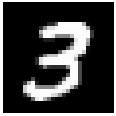

In [56]:
show_image(x_imgs[7])

<Axes: >

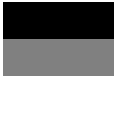

In [58]:
# lets create a kernel

top_edge = tensor([
    [-1,-1,-1],
    [0,0,0],
    [1,1,1]
]).float()

show_image(top_edge)